<a href="https://colab.research.google.com/github/anlianguzova/BI-ML-2023/blob/hw_2/linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score, mean_squared_error,
                             ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_auc_score)
from sklearn.model_selection import train_test_split

In [20]:
plt.rcParams['figure.figsize'] = 12, 9
sns.set_style('whitegrid')

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """

    return np.sum(np.sin(w)**2)

## Задание 1. Градиентный спуск для функции (1 балл)

In [ ]:
def grad_f(w: np.array) -> np.array:
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """

    return np.sin(2*w)

In [ ]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025]))

In [ ]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных.
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """

    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)

        curr_w -= lr*grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

In [ ]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)

    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3,
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()

    return steps

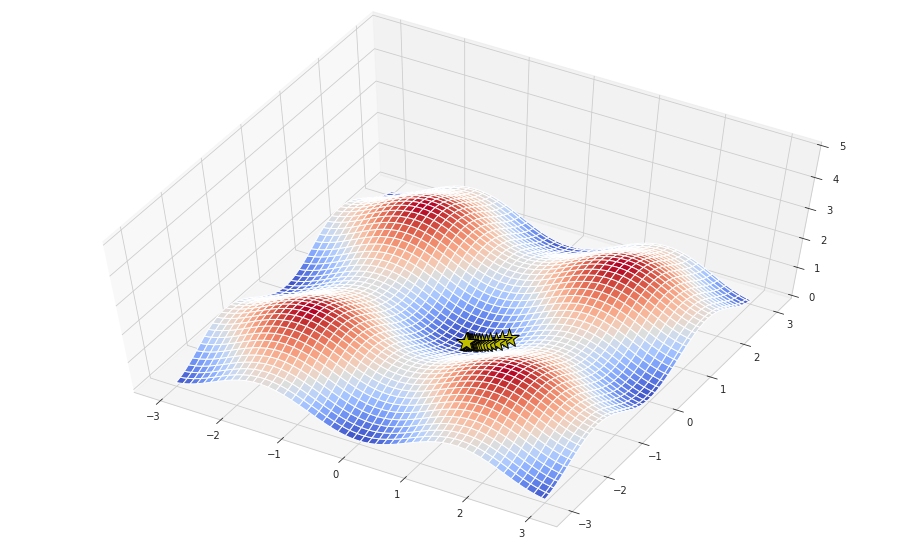

array([[6.12170176e-01, 1.69069754e-01, 3.58530008e-01],
       [5.18111971e-01, 1.35896501e-01, 2.63617887e-01],
       [4.32063314e-01, 1.09050596e-01, 1.87192673e-01],
       [3.56010467e-01, 8.74129774e-02, 1.29100079e-01],
       [2.90673963e-01, 7.00193026e-02, 8.70330987e-02],
       [2.35758870e-01, 5.60611684e-02, 5.76996147e-02],
       [1.90334977e-01, 4.48724122e-02, 3.78042186e-02],
       [1.53180722e-01, 3.59099719e-02, 2.45703538e-02],
       [1.23021572e-01, 2.87341502e-02, 1.58835361e-02],
       [9.86647531e-02, 2.29904829e-02, 1.02316553e-02],
       [7.90596168e-02, 1.83940064e-02, 6.57571257e-03],
       [6.33134986e-02, 1.47160348e-02, 4.21979172e-03],
       [5.06846115e-02, 1.17732528e-02, 2.70533387e-03],
       [4.05650410e-02, 9.41881979e-03, 1.73333171e-03],
       [3.24609300e-02, 7.53516724e-03, 1.11011959e-03],
       [2.59733036e-02, 6.02819084e-03, 7.10799458e-04],
       [2.07809788e-02, 4.82258188e-03, 4.55044035e-04],
       [1.66259795e-02, 3.85808

In [ ]:
steps = gradient_desc_vis(f, grad_f)
steps

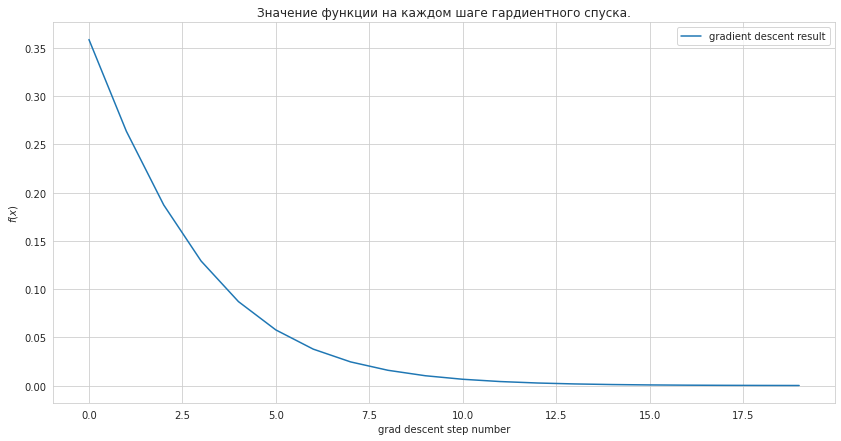

In [ ]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

## Задание 2. Реализация линейной регресии (суммарно 9 баллов)

### Задание 2.1. MSE и ее градиент (2 балла)

In [ ]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 1/len(y_pred) * np.sum((np.square(y_true - y_pred)))

def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return (2 * np.matmul(np.transpose(X), (y_pred - y_true))) / y_pred.shape[0] 


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

In [ ]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

In [ ]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("


### Задание 2.2. Предсказания линейной регрессии (3 балла)

In [ ]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))

        return np.matmul(X_test, self.W)
    
    
    def __repr__(self):
        return "My custom linear regression"

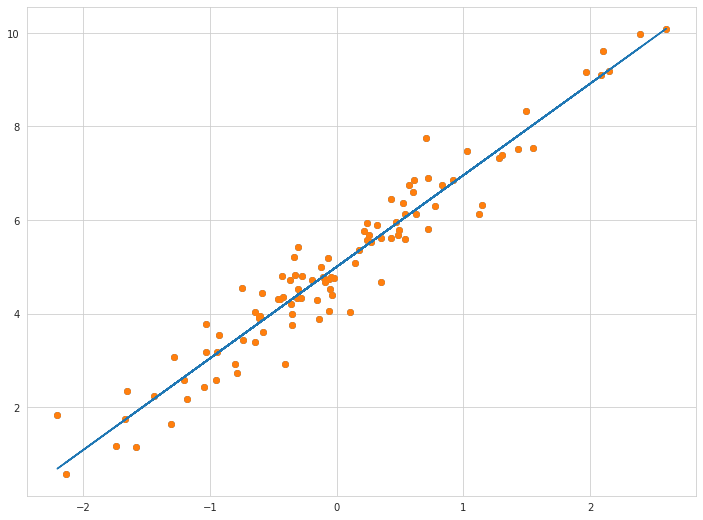

In [ ]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

plt.scatter(X, y);

custom_lin_reg = CustomLinearRegression()

custom_lin_reg.fit(X, y)

plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

In [ ]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [ ]:
X = pd.DataFrame(X)
X.columns = feature_names
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [ ]:
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [ ]:
X.mean(), X.std()

(MedInc           3.870671
 HouseAge        28.639486
 AveRooms         5.429000
 AveBedrms        1.096675
 Population    1425.476744
 AveOccup         3.070655
 Latitude        35.631861
 Longitude     -119.569704
 dtype: float64, MedInc           1.899822
 HouseAge        12.585558
 AveRooms         2.474173
 AveBedrms        0.473911
 Population    1132.462122
 AveOccup        10.386050
 Latitude         2.135952
 Longitude        2.003532
 dtype: float64)

ничегошеньки не стандартизировано, придётся стандартизировать((((((((((

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
scaler = StandardScaler()
X_st_train = scaler.fit_transform(X_train)
X_st_test = scaler.fit(X_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_st_train, y_train)
y_pred = lin_reg.predict(X_st_train)

In [ ]:
mean_squared_error(y_train, y_pred), r2_score(y_train, y_pred)

(0.520385415428215, 0.6086450968922572)

In [ ]:
lin_coefs = lin_reg.coef_
np.argsort(abs(lin_coefs))[::-1][:3]

array([6, 7, 0])

In [ ]:
feature_names[6], feature_names[7], feature_names[0]

('Latitude', 'Longitude', 'MedInc')

вот они самые важные признаки модели слева направо...

## Задание 3. Реализация логистической регресии (суммарно 10 баллов)

### Задание 3.1. Реализация сигмоиды (0.5 баллов)

In [ ]:
def sigmoid(output: int) -> int: 
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.e**(-output))

### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

In [ ]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -1/n * (sum(y_true * np.log(sigmoid(y_pred)) + (1 - y_true) * np.log(1 - y_pred)))
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.matmul(np.transpose(X), (y_pred - y_true))


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)


### Задание 3.3. Предсказания логистической регрессии (2 балла)

In [ ]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(np.matmul(X_test, self.W))
    
    def __repr__(self):
        return "My custom logistic regression"

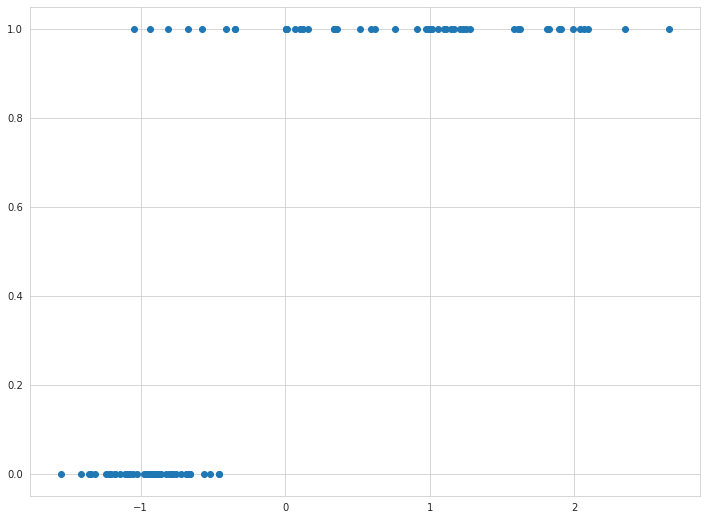

In [ ]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

plt.scatter(X, y);

In [ ]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)


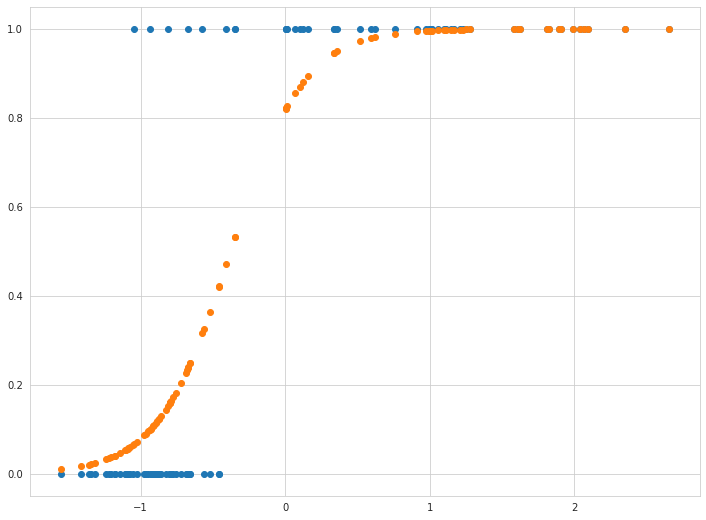

In [ ]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
y_pred = np.where(y_pred >= 0.5, 1, 0)
precision_score(y, y_pred), recall_score(y, y_pred), f1_score(y, y_pred), accuracy_score(y, y_pred)

(1.0, 0.8823529411764706, 0.9375, 0.94)

ну всё ок

### Задание 3.4. Применение логистической регрессии (5 баллов)

In [2]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [3]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [4]:
pokemon.Legendary = pokemon.Legendary.astype(int)

In [5]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


In [6]:
pokemon.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [7]:
pokemon['Type 2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

In [8]:
pokemon['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

какие-то покемоны двухтипные просто, видимо

In [ ]:
pokemon['Name'].unique()

всёёё уникально аааа

In [9]:
pokemon = pokemon.drop(columns=['Name','#']) #меня этот idишник смущает тоже

In [ ]:
pokemon = pokemon.drop(columns=['Type 1', 'Type 2']) #удаляю потому что не придумала как их красиво проанализировать, и уже нет времени думать

In [13]:
pokemon

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,318,45,49,49,65,65,45,1,0
1,405,60,62,63,80,80,60,1,0
2,525,80,82,83,100,100,80,1,0
3,625,80,100,123,122,120,80,1,0
4,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6,1
796,700,50,160,110,160,110,110,6,1
797,600,80,110,60,150,130,70,6,1
798,680,80,160,60,170,130,80,6,1


In [14]:
pokemon_X = pokemon.iloc[:, 0:8]
pokemon_y = pokemon.iloc[:, 8].values

In [16]:
pokemon_X.mean()

Total         435.10250
HP             69.25875
Attack         79.00125
Defense        73.84250
Sp. Atk        72.82000
Sp. Def        71.90250
Speed          68.27750
Generation      3.32375
dtype: float64

In [18]:
pokemon_X.std()

Total         119.963040
HP             25.534669
Attack         32.457366
Defense        31.183501
Sp. Atk        32.722294
Sp. Def        27.828916
Speed          29.060474
Generation      1.661290
dtype: float64

опять придётся всё стандартизировать ((

In [40]:
X_train, X_test, y_train, y_test = train_test_split(pokemon_X, pokemon_y, test_size=0.2, random_state=SEED, 
                                                    stratify=pokemon_y)

In [41]:
scaler = StandardScaler()
X_st_train = scaler.fit_transform(X_train)
X_st_test = scaler.fit(X_test)

In [71]:
log_reg = LogisticRegression()
log_reg.fit(X_st_train, y_train)

LogisticRegression()

In [37]:
X_st_train

array([[-1.32531415, -0.56134371, -0.98923815, ..., -1.13002406,
        -0.93248563, -1.42623482],
       [-0.59606378, -0.36854561,  0.18559688, ..., -0.81176968,
        -0.26697176,  0.40422698],
       [-0.04083906, -0.36854561, -0.89648802, ..., -0.06917613,
        -0.09183653, -0.20592695],
       ...,
       [ 0.87072392,  3.48741631,  0.95851467, ...,  1.34528779,
        -1.31778313, -1.42623482],
       [-0.66235927, -0.59990333, -0.0308201 , ..., -0.95321607,
        -1.59799949,  1.01438092],
       [-1.28387947, -0.56134371, -0.12357023, ..., -1.66044803,
        -1.84318881,  1.01438092]])

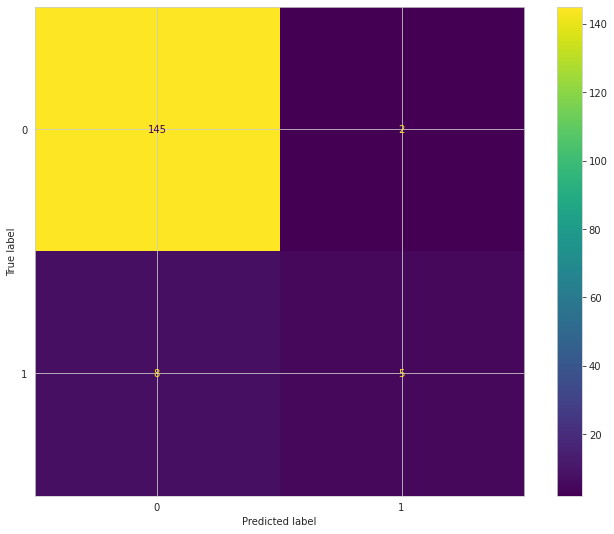

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

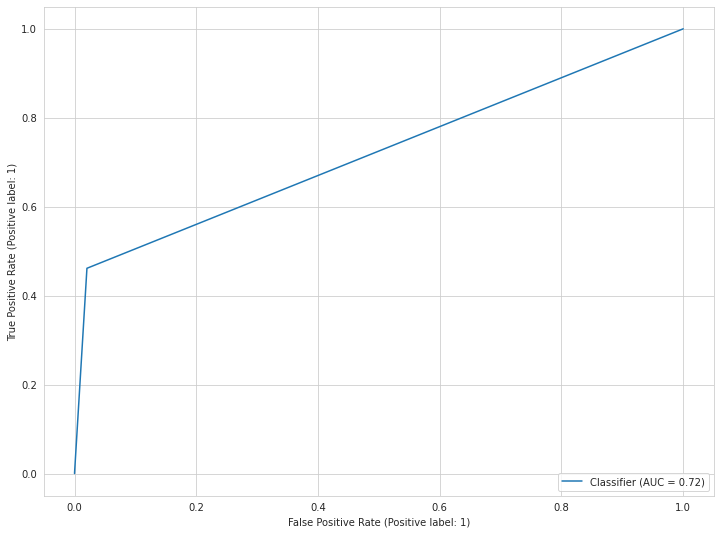

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [48]:
roc_auc_score(y_test, y_pred) # AUC - площадь под кривой

0.6855049712192569

In [78]:
log_reg.coef_

array([[1.10224647, 0.75597527, 0.27400993, 0.64471501, 0.84405805,
        0.94183062, 1.04962412, 0.56286891]])

In [85]:
pokemon_X.iloc[:, [0,5,6]] #влияет больше всего на легендарность. 

,Total,Sp. Def,Speed
0,318,65,45
1,405,80,60
2,525,100,80
3,625,120,80
4,309,50,65
...,...,...,...
795,600,150,50
796,700,110,110
797,600,130,70
798,680,130,80


## Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

у меня её нет, к сожалению (или счастью). в основном отдельные треки слушаю. из последнего заслушенного --- океан ельзи, shortparis, mardrugada, shanti people, аигел 